# Training Your First Model

In this section, you'll train a simple feedforward neural network on the MNIST using Deeplay. You'll define the model, loss function, optimizer, and training loop, and then train the model on the dataset.

## Loading the Dataset

Data can come from anywhere. MNIST is most easily loaded using the torchvision library, which provides a simple interface for downloading and loading common datasets. Here, you'll load the MNIST dataset and create a PyTorch DataLoader to iterate over the dataset in batches.

In [1]:
import torchvision

mnist_train = torchvision.datasets.MNIST(
    root="data", 
    train=True, 
    download=True, 
    transform=torchvision.transforms.ToTensor(),
)
mnist_val = torchvision.datasets.MNIST(
    root="data", 
    train=False, 
    download=True, 
    transform=torchvision.transforms.ToTensor(),
)

Failed to download (trying next):
<urlopen error [Errno 8] nodename nor servname provided, or not known>

Failed to download (trying next):
<urlopen error [Errno 8] nodename nor servname provided, or not known>



RuntimeError: Error downloading train-images-idx3-ubyte.gz

## Creating the Model

Next, define the model architecture by creating a simple feedforward neural network with two hidden layers and ReLU activation functions. The input size is 784 (28x28 pixels), and the output size is 10 (one for each digit). You don't need any activation function on the output layer, as ypou'll use the `CrossEntropyLoss`, which includes a softmax activation.

In [2]:
import deeplay as dl

model = dl.models.SmallMLP(in_features=784, out_features=10)

print(model)

AttributeError: module 'deeplay.models' has no attribute 'SmallMLP'

## Creating the Application

Now, create the application, which includes the model, loss function, optimizer, and training loop. You'll use the `CategoricalClassifier` application, which is a pre-built application for categorical classification tasks, which sets the correct loss and adds useful metrics.

In [26]:
classifier = dl.CategoricalClassifier(model, num_classes=10, optimizer=dl.Adam(lr=0.001))

print(classifier)

CategoricalClassifier(
  (loss): CrossEntropyLoss()
  (train_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=train
  )
  (val_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=val
  )
  (test_metrics): MetricCollection(
    (MulticlassAccuracy): MulticlassAccuracy(),
    prefix=test
  )
  (model): SmallMLP(
    (blocks): LayerList(
      (0): LinearBlock(
        (layer): Layer[Linear](in_features=784, out_features=32, bias=True)
        (activation): Layer[LeakyReLU](negative_slope=0.05)
        (normalization): Layer[BatchNorm1d](num_features=32)
      )
      (1): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=32, bias=True)
        (activation): Layer[LeakyReLU](negative_slope=0.05)
        (normalization): Layer[BatchNorm1d](num_features=32)
      )
      (2): LinearBlock(
        (layer): Layer[Linear](in_features=32, out_features=10, bias=True)
        (activation): Layer[Identi

## Training the Model

Finally, train the model using the `fit()` method of the application. You just need to provide the data and the number of epochs. The `fit()` method will handle the rest, including the training loop, validation, and logging. You'll pass both the training and the test data. The model will log the loss and accuracy on both datasets, but it'll only update the weights based on the training data. Of course, we use the GPU on your machine if available.

In [68]:
h = classifier.fit(train_data=mnist_train, val_data=mnist_val, max_epochs=10, batch_size=128)

┏━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name          ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ loss          │ CrossEntropyLoss │      0 │
│ 1 │ train_metrics │ MetricCollection │      0 │
│ 2 │ val_metrics   │ MetricCollection │      0 │
│ 3 │ test_metrics  │ MetricCollection │      0 │
│ 4 │ model         │ SmallMLP         │ 26.6 K │
│ 5 │ optimizer     │ Adam             │      0 │
└───┴───────────────┴──────────────────┴────────┘

Trainable params: 26.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 26.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

c:\Users\bmidt\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_
connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

c:\Users\bmidt\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_
connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing 
the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

The output of the fit method contains the training history. You can plot the loss and accuracy over time to see how the model is improving, and check if it's overfitting.

(<Figure size 1500x500 with 2 Axes>,
 array([<AxesSubplot: title={'center': 'Loss'}, xlabel='Step'>,
        <AxesSubplot: title={'center': 'Multiclassaccuracy'}, xlabel='Step'>],
       dtype=object))

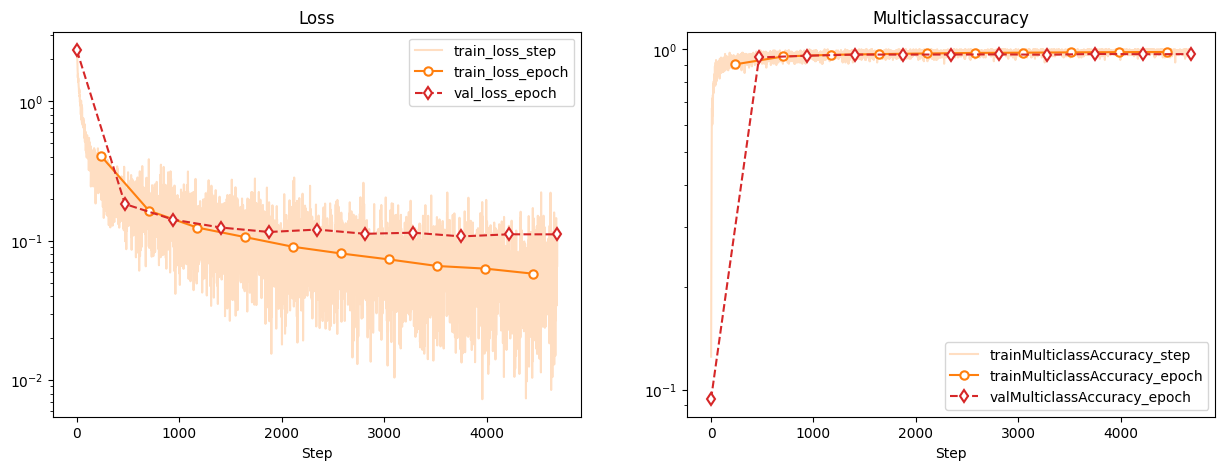

In [ ]:
h.plot()

**Tip:** If you forgot to store the output of the fit method, you can access the training history using the `trainer.history` attribute of the application (here `classifier.trainer.history`).

## Saving the Model and Doing Inference

During training, the last model checkpoint is automatically saved. You should see it under the `lightning_logs` directory. You can also save the model manually using the `save()` method. The best way to do this is to save the state dictionary, which contains the model weights and optimizer state. You can then load the model using the `load()` method.

In [ ]:
import torch

torch.save(classifier.state_dict(), 'model.pth')  # Saving the model.

classifier.load_state_dict(torch.load('model.pth'))  # Loading the model.

<All keys matched successfully>

Of course, you'll want to use the model for inference. You can do this by calling the model directly with input data. Deeplay provides the `predict()` method as a convenience, which handles moving the data to the correct device and batching it if necessary.

In [ ]:
inputs, labels = zip(*mnist_val)

predicted_scores = classifier.predict(inputs)
predicted_labels = torch.argmax(predicted_scores, dim=1)

for i in range(10):
    suffix = 'Error!' if predicted_labels[i] != labels[i] else ''
    print(f'Predicted: {predicted_labels[i]}, True: {labels[i]} ' + suffix)

Predicted: 7, True: 7 
Predicted: 2, True: 2 
Predicted: 1, True: 1 
Predicted: 0, True: 0 
Predicted: 4, True: 4 
Predicted: 1, True: 1 
Predicted: 4, True: 4 
Predicted: 9, True: 9 
Predicted: 6, True: 5 Error!
Predicted: 9, True: 9 
